# Convergence of the mappings

Study the numerical convergence of mappings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl, matplotlib.pyplot as plt, matplotlib.colors as mplcolors
import numpy as np
from scipy import stats
from neurodyn import *

## Quick test of fast vs naive implementation (sanity check)

In [3]:
def compute_J_ab_naive(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	# a naive implementation to test things out, slow !!
	from tqdm import tqdm
	
	_, bin_index_count = np.unique(mapping_index, return_counts=True)
	J = np.zeros((4**n, 4**n), dtype=float)

	for i in tqdm(range(rnn.N)):
		for j in range(rnn.N):
			if i == j: continue  # skip self-connections
			J[mapping_index[i], mapping_index[j]] += (rnn.F[i] * rnn.G[j]).sum()

	J /= rnn.N

	for alpha in range(4):
		J[alpha, :] /= bin_index_count[alpha]

	return J


def compute_J_ab_naive2(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	from collections import Counter
	# _, bin_index_count = np.unique(bin_index, return_counts=True)
	bin_index_count = Counter(mapping_index)
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in range(4**n):
		if bin_index_count.get(alpha, 0.0) == 0.0: continue
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('im,jm->', rnn.F[mapping_index == alpha, :], rnn.G[mapping_index == beta, :])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('im,im->', rnn.F[mapping_index == alpha, :], rnn.G[mapping_index == beta, :])
		# J[alpha, :] /= bin_index_count[alpha]
		J[alpha, :] /= bin_index_count.get(alpha, 0.0)
		
	J /= rnn.N

	return J

def compute_J_ab(rnn: LowRankRNN, n: int, mapping_index: np.ndarray) -> np.ndarray:
	# store the masks, as is expensive in memory ~O(N)
	binmasks: list[np.ndarray] = [ mapping_index == alpha for alpha in range(4**n) ]
	bincounts = np.array([ binmasks[alpha].sum() for alpha in range(4**n) ])
	binF = [ rnn.F[binmasks[alpha], :] for alpha in range(4**n) ]
	binG = [ rnn.G[binmasks[alpha], :] for alpha in range(4**n) ]
	J = np.zeros((4**n, 4**n), dtype=float)

	for alpha in range(4**n):
		if bincounts[alpha] == 0: continue  # empty bins correspond 
		for beta in range(4**n):
			J[alpha, beta] += np.einsum('am,bm->', binF[alpha], binG[beta])
			if alpha == beta:  # exclude self connections
				J[alpha, beta] -= np.einsum('am,am->', binF[alpha], binG[beta])
		J[alpha, :] /= bincounts[alpha]
		
	J /= rnn.N

	return J

In [4]:
rnn = LowRankRNN.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
mapping = RecursiveQuadrantMapping(n=1)
indices = mapping.indices(rnn.F)
print(f'{indices[:20]=}')

print('-- naive method --')
# print(compute_J_ab_naive(rnn, mapping.n, mapping_index))

print('-- fast method --')
# for this setup : 
# rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
# n = 4
# -> 9.48 s ± 1.64 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
print(compute_J_ab_naive2(rnn, mapping.n, indices))

print('-- faster method --')
print(compute_J_ab(rnn, mapping.n, indices))
# -> 3.33 s ± 46.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

print('-- implemented -- ')
print(rnn.params.to_binmapped(mapping).to_dense().J)

indices[:20]=array([0, 2, 2, 1, 2, 3, 2, 1, 1, 1, 3, 1, 1, 2, 0, 1, 3, 2, 1, 2])
-- naive method --
-- fast method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- faster method --
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]
-- implemented -- 
[[ 1.45119276  0.28966982 -1.98461211  0.33203223]
 [ 0.22657076  1.73885271 -0.2716881  -1.66248461]
 [-1.03859207 -0.20251376  1.40162736 -0.23897197]
 [ 0.18679833 -1.6010005  -0.28783173  1.68041624]]


In [5]:
# without self-connections
LowRankRNNParams.new_valentin(p=2, N=1000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)\
	.to_binmapped(RecursiveQuadrantMapping(n=1))\
	.to_dense().J

array([[ 1.46261282,  0.28966982, -1.98461211,  0.33203223],
       [ 0.22657076,  1.74857855, -0.2716881 , -1.66248461],
       [-1.03859207, -0.20251376,  1.40932715, -0.23897197],
       [ 0.18679833, -1.6010005 , -0.28783173,  1.69022041]])

## Visualize binning of the $J_{ij}$ matrix

In [6]:
params = LowRankRNNParams.new_valentin(p=2, N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
mapping = RecursiveQuadrantMapping(n=4)  # 4**n = 4**4 = 256 boxes along each axis
indices = mapping.indices(params.F)
mapping_value = mapping(params.F)

# generate dense matrix
idx_sort = np.argsort(mapping_value)
J_dense = params.to_dense().J[idx_sort, :][:, idx_sort]

# bin dense matrix
xx, yy = np.meshgrid(mapping_value[idx_sort], mapping_value[idx_sort])
flatcoords = np.vstack((xx.flatten(), yy.flatten())).T  # we need to flatten J in order to interpolate each component on the (alpha, beta) coordinates
J_binned = stats.binned_statistic_2d(
	flatcoords[:, 0], flatcoords[:, 1], J_dense.flat,
	statistic='sum', bins=[np.linspace(0, 1, mapping.num_bins+1), np.linspace(0, 1, mapping.num_bins+1)],
).statistic

# rescale
J_rescaled = J_binned.copy()
J_rescaled = np.nan_to_num(J_rescaled, nan=0.0)
for alpha in range(mapping.num_bins):
	bincount = (indices == alpha).sum()
	if bincount == 0: continue
	J_rescaled[alpha, :] /= bincount
# J_rescaled /= rnn.N  # we don't need to rescale by N, because J is already divided by N

# the mathematically true result
J_ab = params.to_binmapped(mapping).to_dense().J

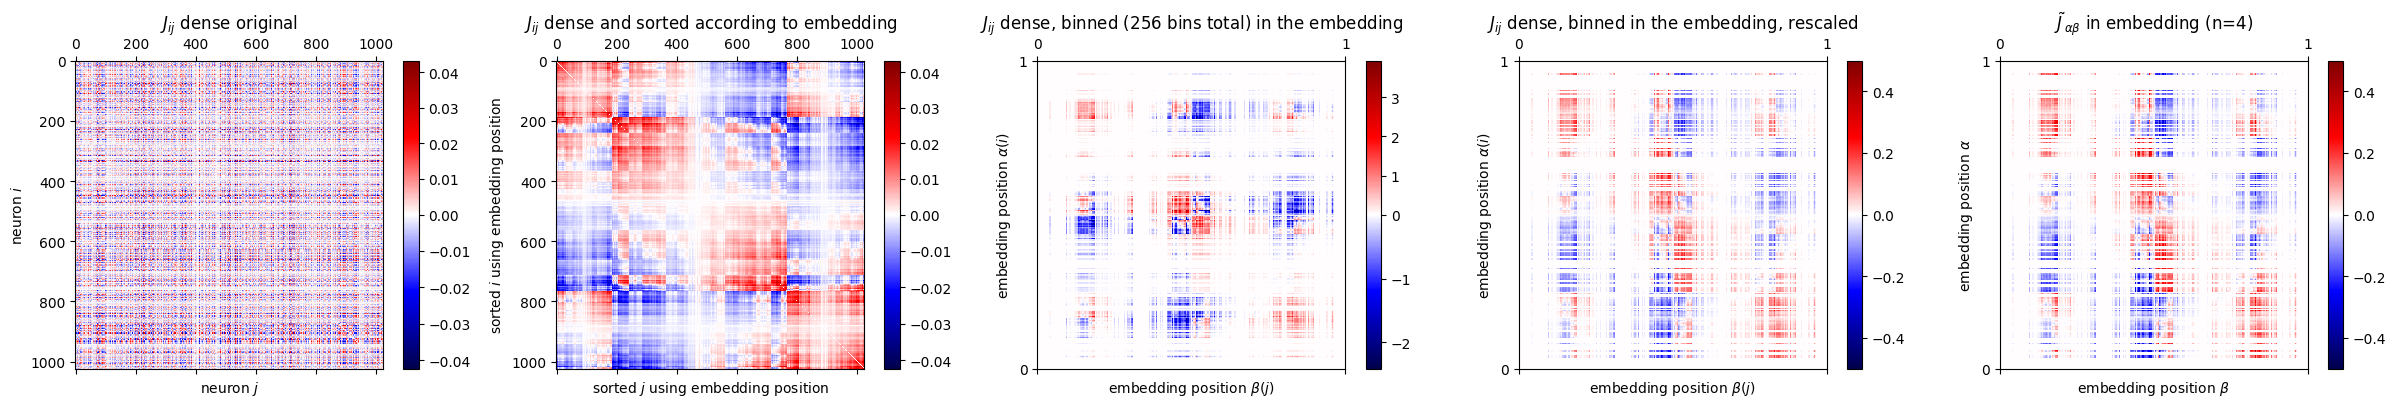

In [7]:
fig, axes = plt.subplots(figsize=(30, 4), ncols=5)

axes[0].set_title('$J_{ij}$ dense original')
axes[0].set_xlabel('neuron $j$')
axes[0].set_ylabel('neuron $i$')
axes[1].set_title('$J_{ij}$ dense and sorted according to embedding')
axes[1].set_xlabel('sorted $j$ using embedding position')
axes[1].set_ylabel('sorted $i$ using embedding position')
axes[2].set_title(f'$J_{{ij}}$ dense, binned ({mapping.num_bins} bins total) in the embedding')
axes[2].set_xlabel('embedding position $\\beta(j)$')
axes[2].set_ylabel('embedding position $\\alpha(i)$')
axes[3].set_title('$J_{ij}$ dense, binned in the embedding, rescaled')
axes[3].set_xlabel('embedding position $\\beta(j)$')
axes[3].set_ylabel('embedding position $\\alpha(i)$')
axes[4].set_title(f'$\\tilde J_{{\\alpha\\beta}}$ in embedding (n={mapping.n})')
axes[4].set_xlabel('embedding position $\\beta$')
axes[4].set_ylabel('embedding position $\\alpha$')

im = axes[0].matshow(params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
fig.colorbar(im, ax=axes[0])

im = axes[1].matshow(J_dense, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
fig.colorbar(im, ax=axes[1])

im = axes[2].matshow(J_binned, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[2])

im = axes[3].matshow(J_rescaled, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[3])

im = axes[4].matshow(J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0, vmin=-0.5, vmax=0.5), extent=((0,1,0,1)))
fig.colorbar(im, ax=axes[4])

plt.show()

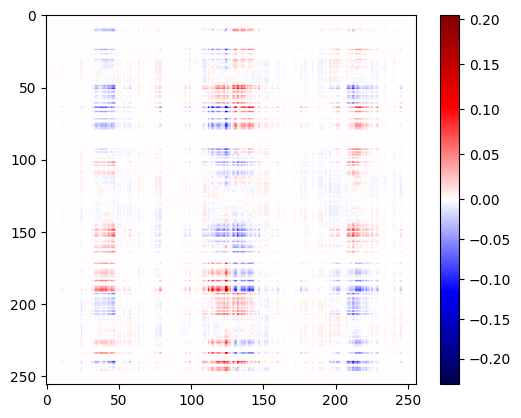

In [8]:
# TODO : why do we still see some difference ? Are these just numerical inaccuracies ?
plt.imshow(J_rescaled - J_ab, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0))
plt.colorbar();

## Implementing low-rank dynamics in the embedding

To test out things, we first compute dynamics by using the explicitly computed (i.e. dense) $\tilde J_{\alpha,\beta}$ matrix.

Then we run the implemented low-rank dynamics

In [9]:
# assert that we get the same recursive currents

rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
h0 = rnn.F[:, 1]
params = rnn.params.to_binmapped(RecursiveQuadrantMapping(n=3))
H0 = params.mapping.binned_statistic(rnn.F, h=h0)
rnn_emb = DenseRNN(params.to_dense())

print(rnn_emb.I_rec(0, H0))

rnn_emb2 = BinMappedRNN(params)
print(rnn_emb2.I_rec(0, H0))

assert np.allclose(rnn_emb.I_rec(0, H0), rnn_emb2.I_rec(0, H0))

[ 0.          0.         -2.18335975 -2.0774715  -3.44826641 -3.21642667
 -2.17072748 -2.1722272  -1.27068528 -1.30628087 -0.41177378 -0.38745156
 -1.42289342 -1.29535713 -0.36997843 -0.33616666 -3.14046551 -3.11079411
 -2.25486695 -2.21556198  0.          0.         -2.16220221 -2.39356845
 -1.31415649 -1.51319371 -0.58149684 -0.47696107 -1.31081013 -1.34338854
 -0.43091396 -0.41766249  0.45715862  0.43600498  1.31753153  1.36993789
  0.40288254  0.44386268  1.29483702  1.32191745  2.21079013  0.
  0.          0.          2.23859336  2.25536173  3.74202864  3.258984
  0.554519    0.51253966  1.39470434  1.42644332  0.48264982  0.4735723
  1.35279277  1.39662595  2.24975241  2.21636378  3.11760334  3.14799594
  2.10858448  2.24270341  0.          0.        ]
[ 0.          0.         -2.18335975 -2.0774715  -3.44826641 -3.21642667
 -2.17072748 -2.1722272  -1.27068528 -1.30628087 -0.41177378 -0.38745156
 -1.42289342 -1.29535713 -0.36997843 -0.33616666 -3.14046551 -3.11079411
 -2.25486695

simulating LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:03<00:00]
simulating DenseRNN{N=256, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=256, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]


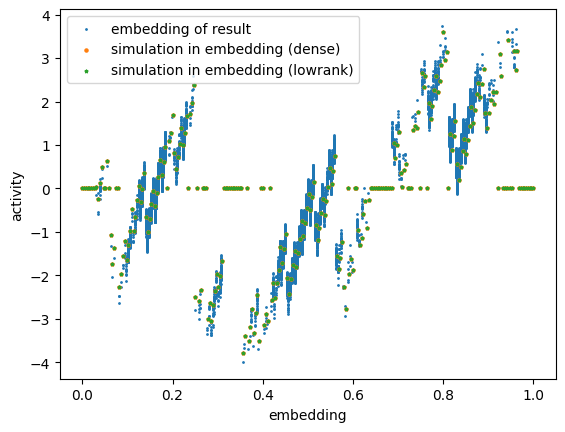

In [10]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
h0 = np.zeros(rnn.N)
res = rnn.simulate(h0=h0, t_span=(0, 40), dt_max=1, progress=True)

mparams = rnn.params.to_binmapped(RecursiveQuadrantMapping(n=4))
H0 = mparams.mapping.binned_statistic(rnn.F, h0)
rnn_embdense = DenseRNN(mparams.to_dense())
res_embdense = rnn_embdense.simulate(h0=H0, t_span=(0, 40), dt_max=1, progress=True)
rnn_emb = BinMappedRNN(mparams)
res_emb = rnn_emb.simulate(h0=H0, t_span=(0, 40), dt_max=1, progress=True)

fig, ax = plt.subplots()
ax.scatter(mparams.mapping(rnn.F), res.h[:, -1], s=1, label='embedding of result')
ax.scatter(np.linspace(0, 1, mparams.mapping.num_bins), res_embdense.h[:, -1], s=5, label='simulation in embedding (dense)')
ax.scatter(np.linspace(0, 1, mparams.mapping.num_bins), res_emb.h[:, -1], s=5, marker='*', label='simulation in embedding (lowrank)')
ax.legend()
ax.set_xlabel('embedding')
ax.set_ylabel('activity')
plt.show()

## Overlaps in the embedding

simulating LowRankRNN{N=20000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:02<00:00]
simulating BinMappedRNN{N=1024, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=True}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]


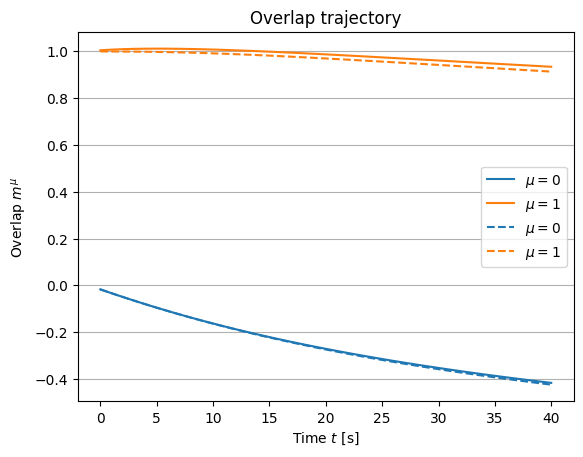

In [11]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)
h0 = rnn.F[:, 1]
res = rnn.simulate(h0, [0, 40], 1, True)
params = rnn.params.to_binmapped(RecursiveQuadrantMapping(n=5))
H0 = params.mapping.binned_statistic(rnn.F, h=h0)
rnn_emb = BinMappedRNN(params)
res_emb = rnn_emb.simulate(H0, [0, 40], 1, True)

figax = plt.subplots()
plot_overlap_trajectory(rnn, res, figax=figax)
figax[1].set_prop_cycle(None)  # reset color cycle to get the same colors
plot_overlap_trajectory(rnn_emb, res_emb, figax=figax, linestyle='--')
plt.show()

## Simulate convergence

Note : now we don't care about self-connections, as we are taking $N$ very large. This also speeds up the simulations

simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:10<00:00]
simulating BinMappedRNN{N=4, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=16, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=64, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=256, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=1024, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating BinMappedRNN{N=4096, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]


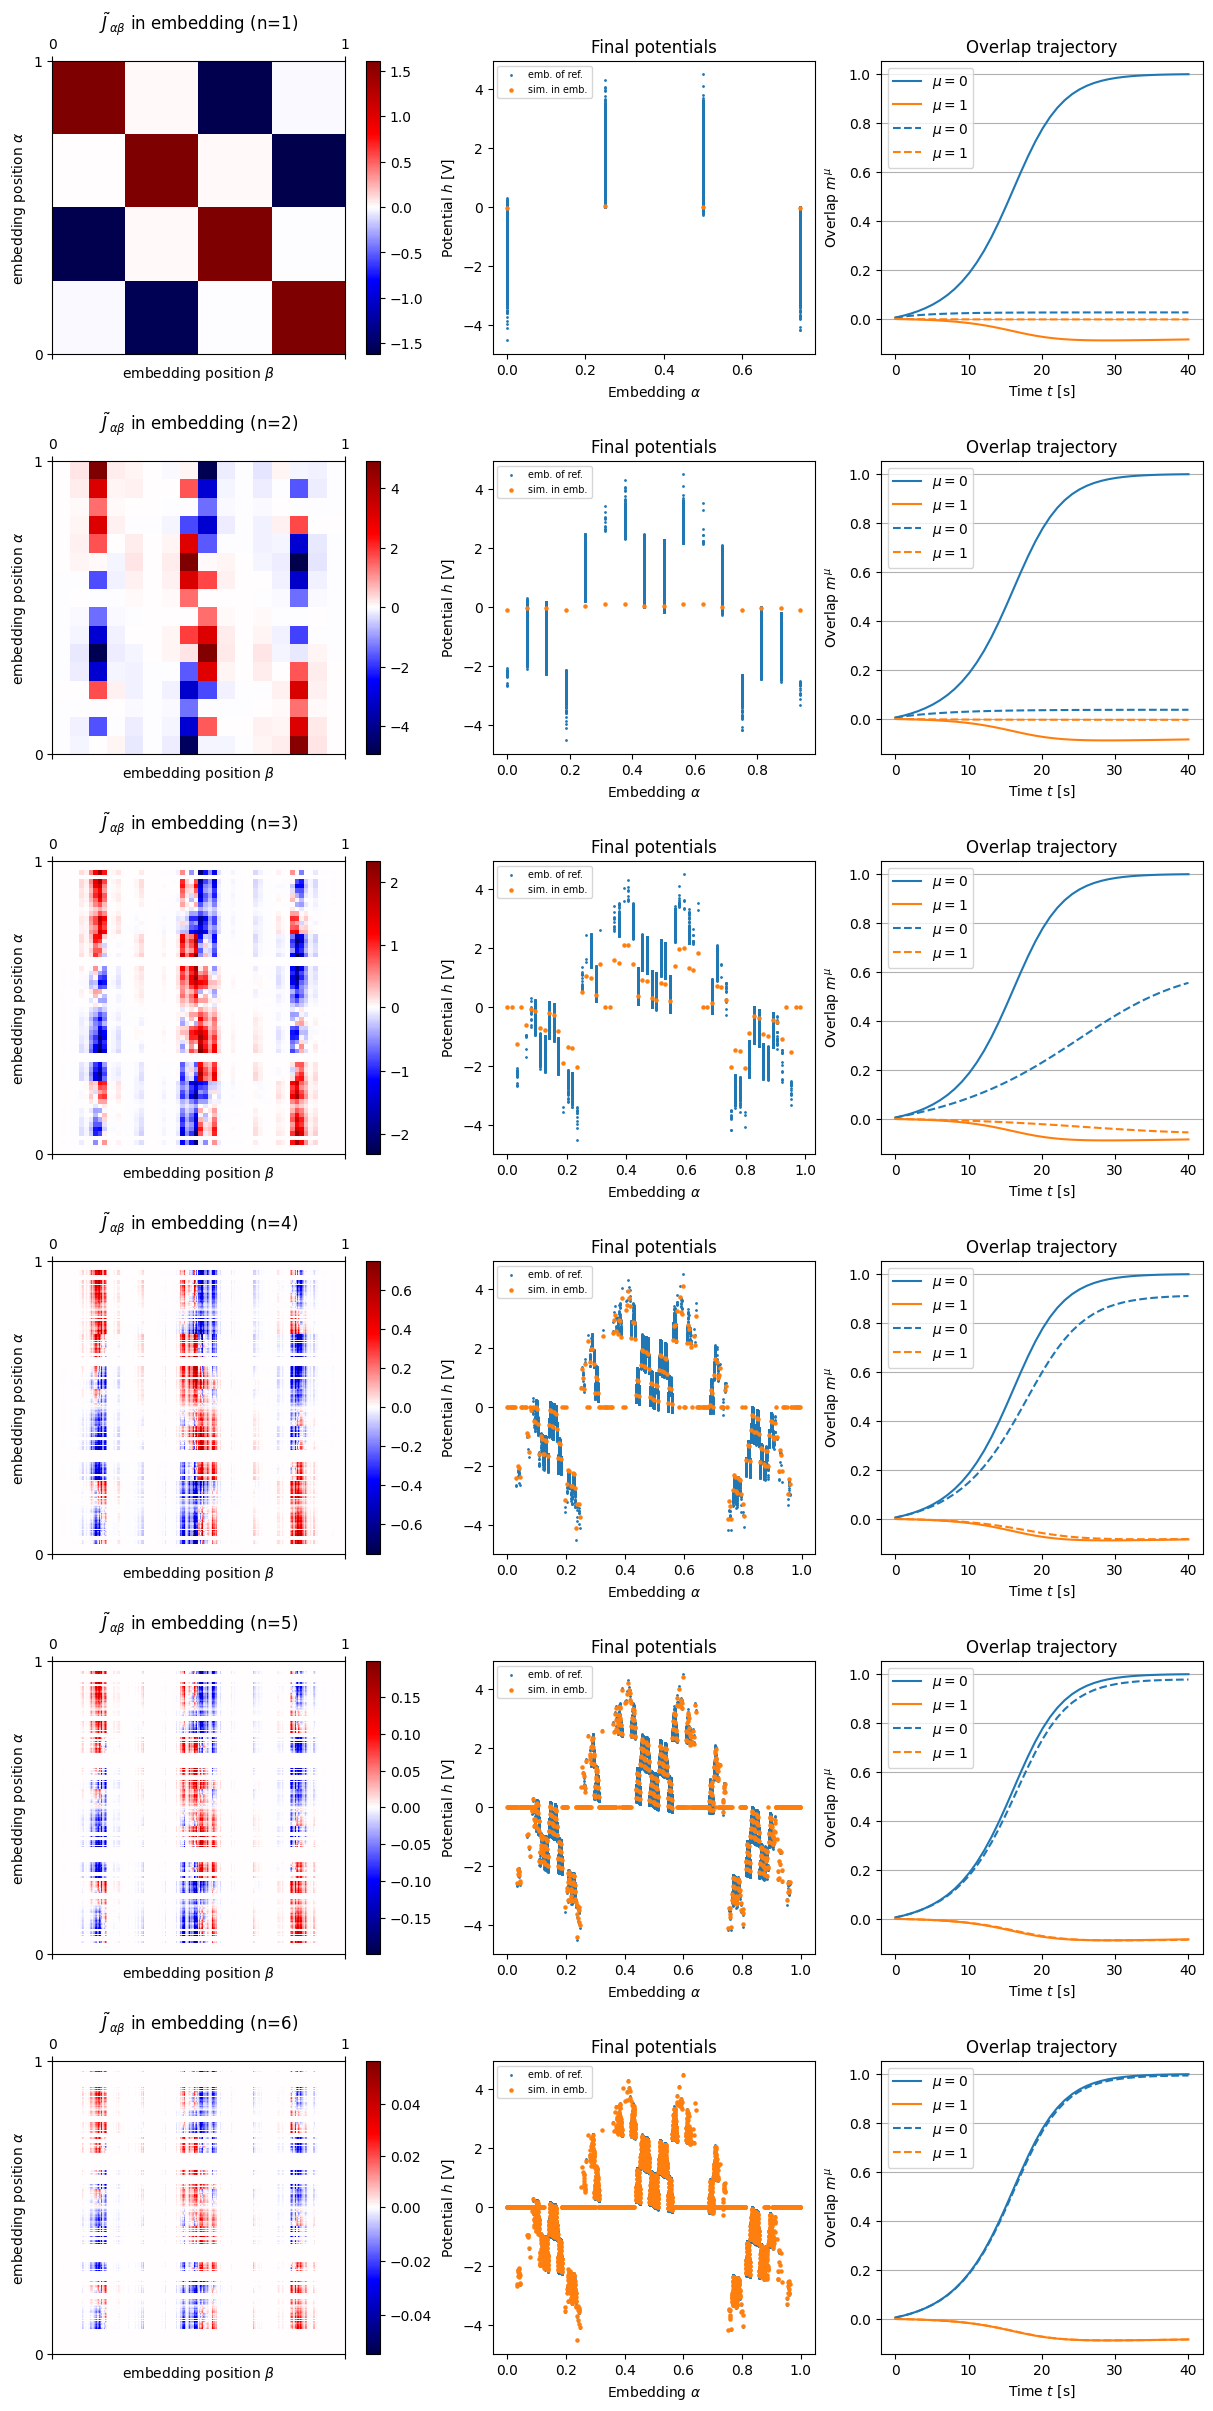

In [12]:
ns = [1, 2, 3, 4, 5, 6]
fig, axes = plt.subplots(ncols=3, nrows=len(ns), figsize=(3*4, len(ns)*4), constrained_layout=True)

rnn = LowRankRNN.new_valentin(p=2, N=100_000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)
res = rnn.simulate(h0=np.zeros(rnn.N), t_span=(0, 40), dt_max=1, progress=True)
for ax, n in zip(axes, ns):
	rnn_emb = BinMappedRNN(rnn.params.to_binmapped(RecursiveQuadrantMapping(n=n)))
	res_emb = rnn_emb.simulate(h0=np.zeros(rnn_emb.N), t_span=(0, 40), dt_max=1, progress=True)

	ax[0].set_title(f'$\\tilde J_{{\\alpha\\beta}}$ in embedding (n={rnn_emb.mapping.n})')
	ax[0].set_xlabel('embedding position $\\beta$')
	ax[0].set_ylabel('embedding position $\\alpha$')
	im = ax[0].matshow(rnn_emb.params.to_dense().J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
	fig.colorbar(im, ax=ax[0])

	ax[1].set_xlabel('Embedding $\\alpha$')
	ax[1].set_ylabel('Potential $h$ [V]')
	ax[1].set_title('Final potentials')
	ax[1].scatter(rnn_emb.mapping(rnn.F), res.h[:, -1], s=1, label='emb. of ref.')
	ax[1].scatter(np.linspace(0, 1-1/rnn_emb.N, rnn_emb.N), res_emb.h[:, -1], s=5, label='sim. in emb.')
	ax[1].legend(loc='upper left', fontsize='x-small')

	plot_overlap_trajectory(rnn, res, figax=(fig, ax[2]))
	ax[2].set_prop_cycle(None)  # reset color cycle
	plot_overlap_trajectory(rnn_emb, res_emb, figax=(fig, ax[2]), linestyle='--')

## Mapping back to $\mathbb R^p$

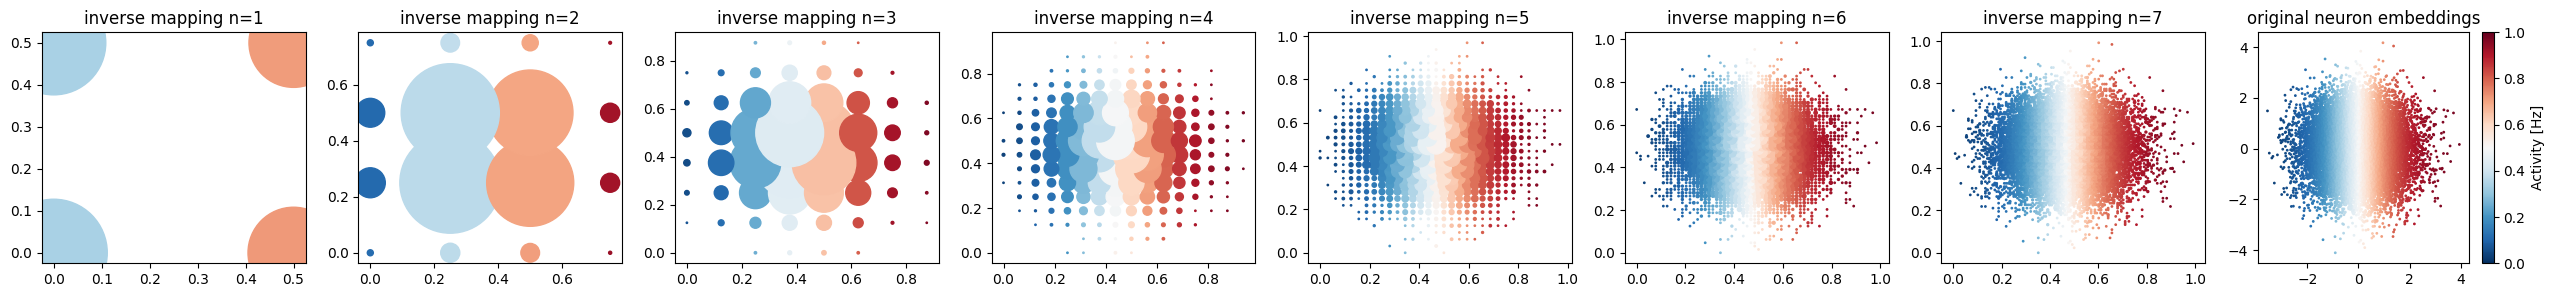

In [13]:
rnn = LowRankRNN.new_valentin(p=2, N=20_000, phi=sigmoid, I_ext=zero, exclude_self_connections=True)

ns = [1,2,3,4,5,6,7]
fig, axes = plt.subplots(ncols=len(ns)+1, figsize=(4*(len(ns)+1), 3))
h0 = rnn.F[:, 0]

for n, ax in zip(ns, axes):
	mapping = RecursiveQuadrantMapping(n=n)
	indices = mapping.indices(rnn.F)
	idx_sort = np.argsort(indices)
	coords = mapping.indices_to_coords(indices)
	assert (coords == mapping.coords(rnn.F)).all()  # sanity check

	F_inverse = mapping.inverse(coords)
	F_inverse = F_inverse[idx_sort]  # sort in order of embedding
	_, idx_unique, idx_inverse, counts = np.unique(F_inverse, return_index=True, return_inverse=True, return_counts=True, axis=0)
	F_unique = F_inverse[np.sort(idx_unique)]  # we do this because we want the unique elements in order or apparition in the original array, not sorted by numpy
	counts = counts[idx_inverse[np.sort(idx_unique)]]

	# manually for sanity check
	# we do a binned statistic, but only on the bins that actually have neurons in them
	# instead, we can sort rnn.F given to binned statistic, and discard nan values
	# h0_binned = np.array([ h0[idx_sort][(F_unique[i] == F_inverse).all(axis=1)].mean() for i in range(len(F_unique)) ])
	
	h0_binned = mapping.binned_statistic(rnn.F[idx_sort], h0[idx_sort], fill_na=None)
	h0_binned = h0_binned[~np.isnan(h0_binned)]

	ax.scatter(F_unique[:, 0], F_unique[:, 1], c=rnn.phi(h0_binned), cmap='RdBu_r', s=counts, vmin=0, vmax=1)
	ax.set_title(f'inverse mapping {n=}')

sc = axes[-1].scatter(*rnn.F.T, s=1, c=rnn.phi(h0), cmap='RdBu_r', vmin=0, vmax=1)
axes[-1].set_title('original neuron embeddings')
fig.colorbar(sc, label='Activity [Hz]')

plt.show()

## Integral formulation

Now we don't bin the neurons, we directly simulate the integral

In [14]:
# TODO : this needs to be harmonized with the LowRankRNNParams.new_valentin function (this is just a copy-paste)

def rho(z):
	"""R^p PDF
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the PDF at the points ``z``
	"""
	return 1/np.sqrt(2*np.pi)*np.exp(-np.linalg.norm(z, axis=1)**2/2)

def phi(z):
	return sigmoid(z)

z0 = np.random.default_rng(42).normal(loc=0, scale=1, size=1_000_000)
phi_z0 = phi(z0)
a, c = np.mean(phi_z0), np.var(phi_z0)

def phi_tilde(z):
	return (phi(z) - a) / c

def w(z, y):
	"""Connectivity kernel from position ``y`` to ``z``
	
	Parameters
	----------
	z : np.ndarray of shape (N, p)
		receiving position in R^p
	y : np.ndarray of shape (N, p)
		emitting position in R^p

	Returns
	-------
	np.ndarray of shape (N,)
		values of the connectivity kernel between ``y`` and ``z``
	"""
	return (phi_tilde(y) * z).sum(axis=1)

In [15]:
def compute_J_ab_integral_naive(mapping, Z):
	# slow way
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		for alpha in range(mapping.num_bins):
			J[alpha, beta] += w(Z[alpha][None, :], Z[beta][None, :])
		J[:, beta] *= rho(Z[beta][None, :])

	J /= rho(Z).sum()
	return J

def compute_J_ab_integral_naive2(mapping, Z):
	J = np.zeros((mapping.num_bins, mapping.num_bins))

	for beta in range(mapping.num_bins):
		J[:, beta] += w(Z, Z[beta][None, :]) * rho(Z[beta][None, :])

	J /= rho(Z).sum()  # renormalize
	return J

def compute_J_ab_integral(mapping, Z):
	return np.einsum('im,jm,j->ij', Z, phi_tilde(Z), rho(Z)) / rho(Z).sum()

In [16]:
mapping = RecursiveQuadrantMapping(n=1)
Z = mapping.inverse(mapping.indices_to_coords(np.arange(mapping.num_bins, dtype=int)))
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)  # now we rescale Z to span the bbox [-4,4]²
Z[:, 0] = (Z[:, 0]-0.5)*(bbox.xmax - bbox.xmin)
Z[:, 1] = (Z[:, 1]-0.5)*(bbox.ymax - bbox.ymin)

print('-- naive method --')
print(compute_J_ab_integral_naive(mapping, Z))

print('-- naive method 2 --')
print(compute_J_ab_integral_naive2(mapping, Z))

print('-- fast einsum method --')
print(compute_J_ab_integral(mapping, Z))

-- naive method --
[[9.99637292e-06 1.49002798e-02 5.34174679e-03 1.49002798e-02]
 [4.99818646e-06 1.48993838e-02 2.67087340e-03 8.95978208e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.99818646e-06 8.95978208e-07 2.67087340e-03 1.48993838e-02]]
-- naive method 2 --
[[9.99637292e-06 1.49002798e-02 5.34174679e-03 1.49002798e-02]
 [4.99818646e-06 1.48993838e-02 2.67087340e-03 8.95978208e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.99818646e-06 8.95978208e-07 2.67087340e-03 1.48993838e-02]]
-- fast einsum method --
[[9.99637292e-06 1.49002798e-02 5.34174679e-03 1.49002798e-02]
 [4.99818646e-06 1.48993838e-02 2.67087340e-03 8.95978208e-07]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [4.99818646e-06 8.95978208e-07 2.67087340e-03 1.48993838e-02]]


simulating LowRankRNN{N=100000, p=2, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:09<00:00]  
simulating DenseRNN{N=4, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating DenseRNN{N=16, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating DenseRNN{N=64, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating DenseRNN{N=256, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:00<00:00]
simulating DenseRNN{N=1024, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:01<00:00]
simulating DenseRNN{N=4096, phi=sigmoid, I_ext=zero, exclude_self_connections=False}: 100.00%|██████████| t=40.000 of 40 [00:12<00:00]  


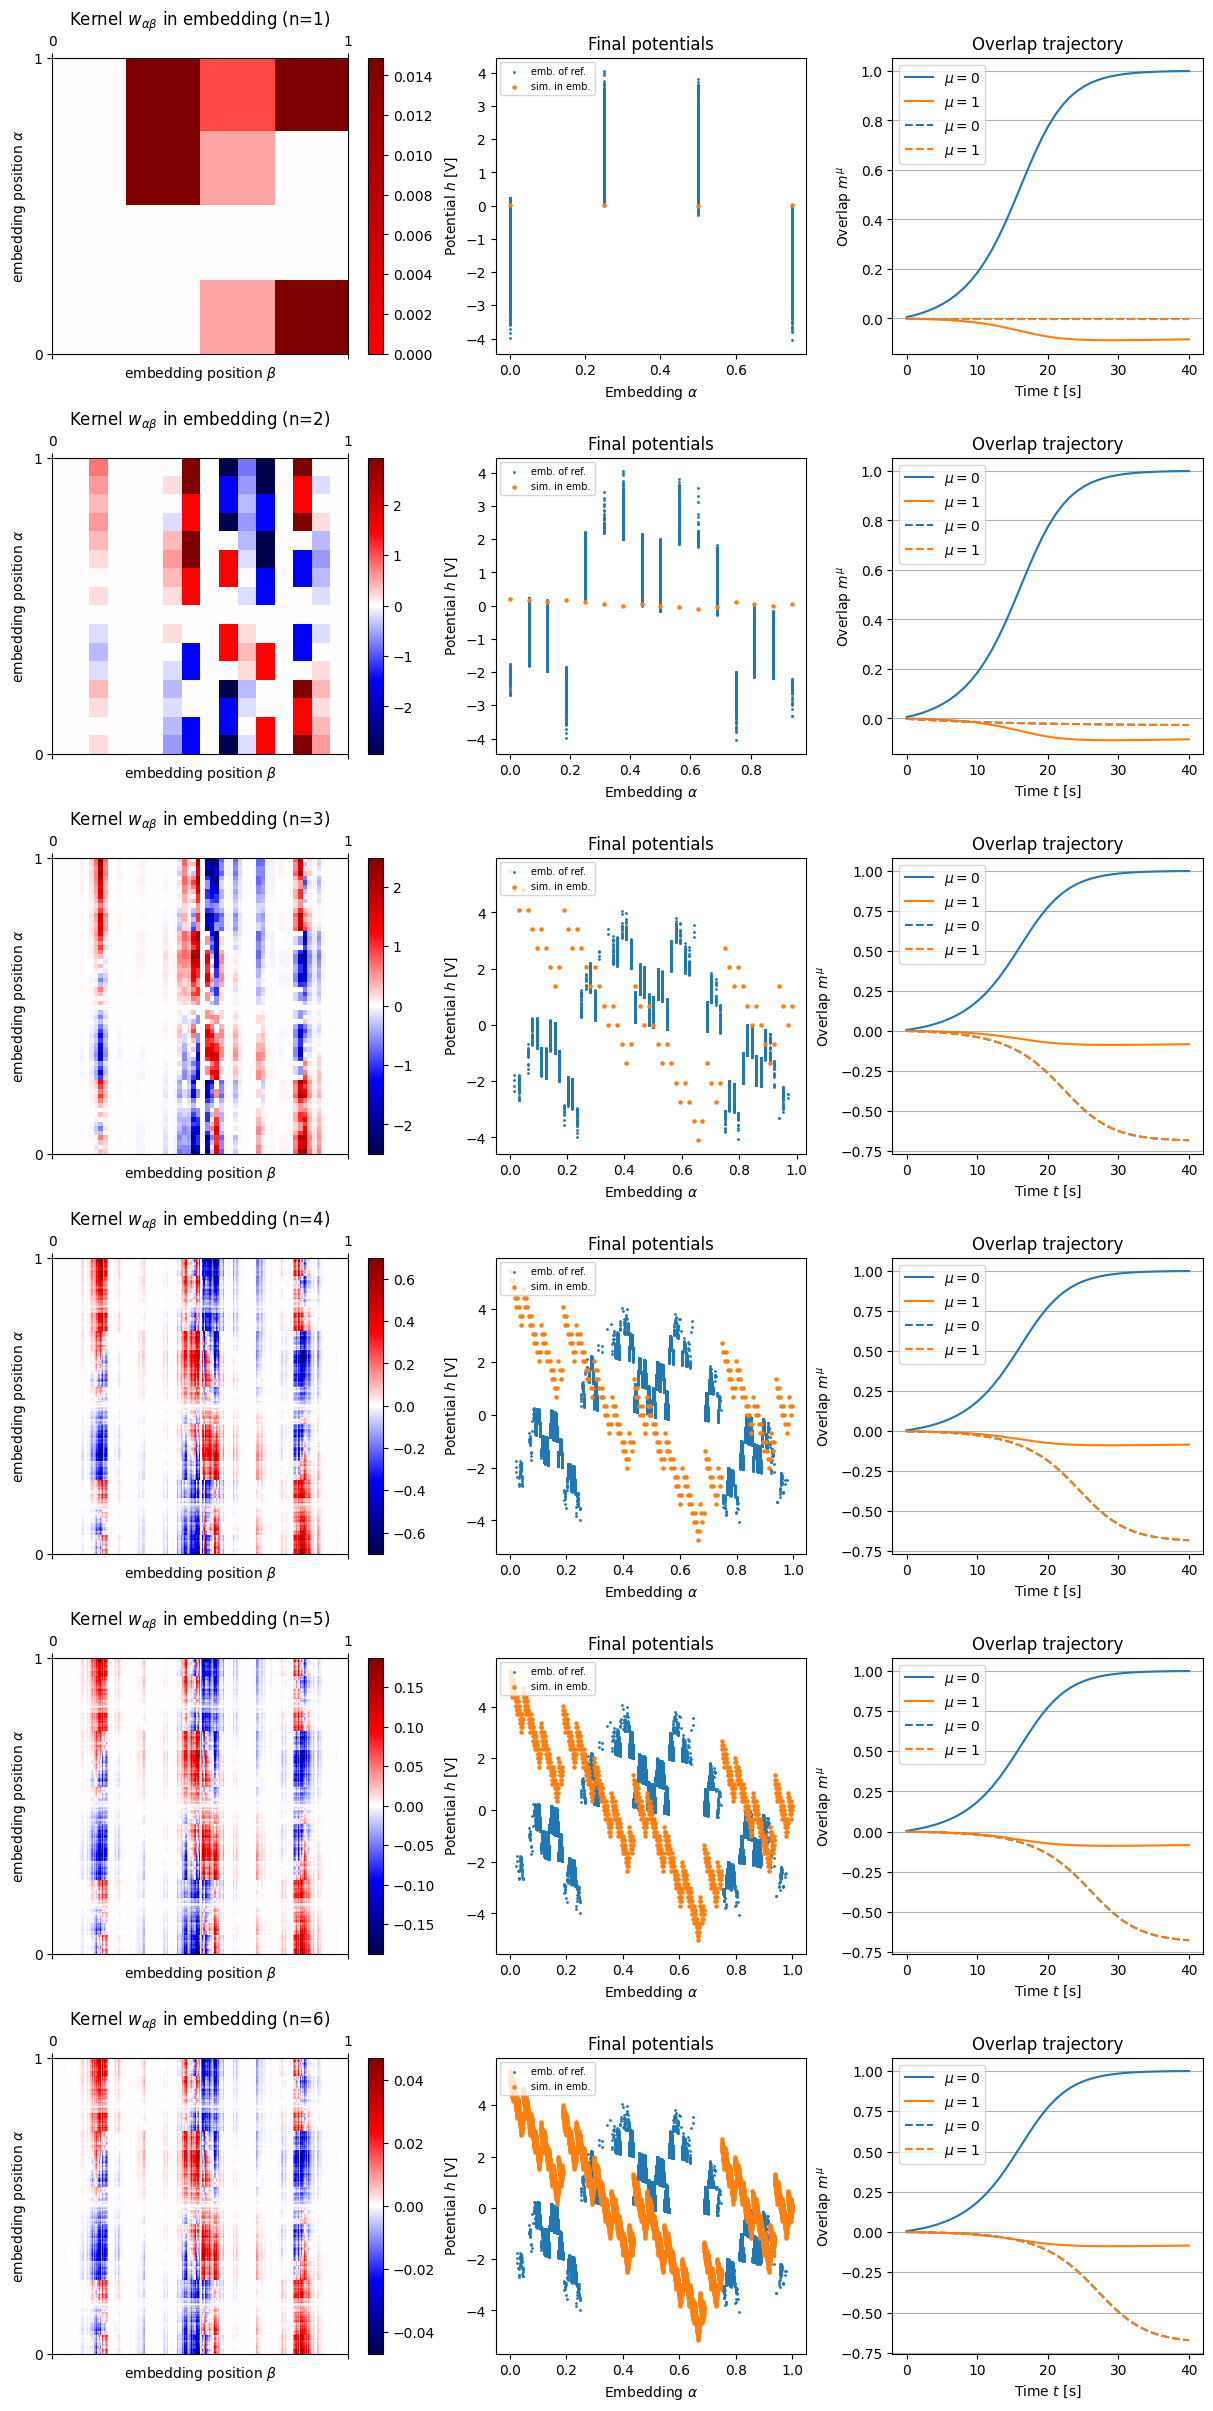

In [17]:
# TODO : something here is not working, I should be getting the same results as the binned
# When we start from a pattern mu, it works, but it doesn't have the same dynamics when we start from h=0

ns = [1, 2, 3, 4, 5, 6]
# ns = [1, 2, 3]
fig, axes = plt.subplots(ncols=3, nrows=len(ns), figsize=(3*4, len(ns)*4), constrained_layout=True)

rnn_ref = LowRankRNN.new_valentin(p=2, N=100_000, phi=sigmoid, I_ext=zero, exclude_self_connections=False)
# Initial conditions mu=0
# res_ref = rnn_ref.simulate(h0=rnn_ref.F[:, 0], t_span=(0, 40), dt_max=1, progress=True)
# Initial conditions h=0
res_ref = rnn_ref.simulate(h0=np.zeros(rnn_ref.N), t_span=(0, 40), dt_max=1, progress=True)
bbox = Box(xmin=-4, xmax=4, ymin=-4, ymax=4)  # the bbox to run the embedded simulation in

for ax, n in zip(axes, ns):
	mapping = RecursiveQuadrantMapping(n=n)
	Z = mapping.inverse(mapping.indices_to_coords(np.arange(mapping.num_bins, dtype=int)))
	# the points Z are now at the lower-left of each bin in [0,1]²
	# Z += np.array([1/4**(mapping.n-1)/2, 1/4**(mapping.n-1)/2])  # center the bins
	Z[:, 0] = (Z[:, 0]-0.5)*(bbox.xmax - bbox.xmin)
	Z[:, 1] = (Z[:, 1]-0.5)*(bbox.ymax - bbox.ymin)
	J = compute_J_ab_integral(mapping, Z)

	rnn_emb = DenseRNN(DenseRNNParams(phi=sigmoid, I_ext=zero, exclude_self_connections=False, J=J))
	res_emb = rnn_emb.simulate(h0=np.zeros(mapping.num_bins), t_span=(0, 40), dt_max=1, progress=True)

	ax[0].set_title(f'Kernel $w_{{\\alpha\\beta}}$ in embedding (n={mapping.n})')
	ax[0].set_xlabel('embedding position $\\beta$')
	ax[0].set_ylabel('embedding position $\\alpha$')
	im = ax[0].matshow(J, cmap='seismic', norm=mplcolors.TwoSlopeNorm(vcenter=0.0), extent=((0,1,0,1)))
	fig.colorbar(im, ax=ax[0])

	mask = bbox.contains(rnn_ref.F)  # WARNING : we need to have the same bounding box for the sampled RNN, and the integral formulation !
	ax[1].set_xlabel('Embedding $\\alpha$')
	ax[1].set_ylabel('Potential $h$ [V]')
	ax[1].set_title('Final potentials')
	ax[1].scatter(mapping(rnn_ref.F[mask], box=bbox), res_ref.h[mask, -1], s=1, label='emb. of ref.')
	ax[1].scatter(mapping(Z), res_emb.h[:, -1], s=5, label='sim. in emb.')
	ax[1].legend(loc='upper left', fontsize='x-small')

	plot_overlap_trajectory(rnn_ref, res_ref, figax=(fig, ax[2]))
	ax[2].set_prop_cycle(None)  # reset color cycle
	m = np.einsum('am,a...,a->m...', phi_tilde(Z), phi(res_emb.h), rho(Z)/rho(Z).sum())
	for mu in range(len(m)):
		ax[2].plot(res_emb.t, m[mu], label=f'$\\mu={mu}$', linestyle='--')
	ax[2].legend()